In [1]:
import pandas as pd
import process_data

# Preprocess data skaters

In [2]:
# list of seasons to consider
# year_list = ['20142015', '20152016', '20162017', '20172018', '20182019', '20192020', '20202021', '20212022', '20222023', '20232024']
year_list = ['20202021', '20212022', '20222023', '20232024']

In [3]:
# find list of teams active between 2014 and 2024
team_id_list = []
for season in year_list:
    for id in process_data.get_season_teams(season):
        if id not in team_id_list:
            team_id_list.append(id)
team_id_list

['EDM',
 'BOS',
 'TOR',
 'COL',
 'CHI',
 'WPG',
 'PIT',
 'VGK',
 'FLA',
 'STL',
 'NYR',
 'CAR',
 'WSH',
 'MIN',
 'DAL',
 'LAK',
 'VAN',
 'SJS',
 'CGY',
 'TBL',
 'NYI',
 'MTL',
 'CBJ',
 'ARI',
 'PHI',
 'BUF',
 'DET',
 'OTT',
 'NJD',
 'ANA',
 'NSH',
 'SEA']

In [4]:
len(team_id_list)

32

In [5]:
# find list of player ids for players who played a game between 2010 and 2020
player_id_list = []
for team in team_id_list:
    for season in year_list:
        for id in process_data.get_all_player_ids(season, team):
            if id not in player_id_list:
                player_id_list.append(id)
player_id_list

[8471707,
 8471729,
 8474068,
 8474589,
 8475163,
 8475178,
 8475179,
 8475197,
 8476326,
 8476454,
 8476457,
 8476886,
 8476913,
 8476915,
 8477498,
 8477934,
 8478021,
 8478402,
 8478451,
 8478452,
 8479344,
 8479466,
 8479977,
 8480802,
 8480803,
 8480946,
 8481638,
 8481813,
 8470281,
 8473544,
 8474089,
 8474098,
 8475169,
 8475786,
 8476495,
 8476879,
 8476967,
 8477943,
 8477998,
 8478442,
 8478585,
 8479338,
 8479347,
 8480041,
 8481598,
 8474218,
 8475218,
 8475760,
 8476850,
 8477406,
 8479576,
 8480011,
 8480468,
 8482077,
 8470621,
 8474040,
 8474641,
 8475842,
 8477015,
 8477454,
 8479442,
 8480274,
 8481534,
 8470638,
 8471276,
 8473419,
 8474000,
 8475186,
 8475225,
 8475735,
 8475745,
 8475780,
 8475791,
 8475797,
 8476191,
 8476374,
 8476422,
 8476891,
 8477320,
 8477365,
 8477508,
 8477941,
 8477956,
 8478075,
 8478131,
 8478415,
 8478443,
 8478468,
 8478485,
 8478498,
 8478888,
 8479325,
 8479365,
 8479546,
 8480001,
 8480021,
 8480901,
 8480944,
 8482072,
 8473422,


In [6]:
len(player_id_list)

1351

In [7]:
# extract data about all players who played between 2010 and 2020, including personal data and stats from every season in the NHL during that period
player_stats = []
for player_id in player_id_list:
    try:
        pl_class = process_data.load_player(player_id, year_list)
        player_stats.append(pl_class)
    except Exception as e:
        print(e)
        continue

'birthCountry'
'birthCountry'
'birthCountry'
'birthCountry'
'birthCountry'
'birthCountry'


In [8]:
# total number of players extracted
len(player_stats)

1345

# Clean data

In [9]:
# restrict to players who played at least 3 seasons and 100 total games
reduced_player_stats = []
for temp in player_stats:
    games = 0
    years = 0
    for year in year_list:
        if year in temp.seasons.keys():
            games += temp.seasons[year].n_games_played
            years += 1
    if years >= 3 and games > 100:
        reduced_player_stats.append(temp)

In [10]:
# number of players with at least 3 seasons and 100 games
len(reduced_player_stats)

645

In [11]:
# create data for prediction, with every possible set of 2 consecutive seasons to predict the 3rd one
split_data = []
for player in reduced_player_stats:
    for i in range(len(year_list) - 2):
        years = year_list[i:i+3]
        if years[2] in player.seasons.keys():
            data = {'name': player.name,
                    'role': player.role,
                    'country': player.country,
                    'age': player.age,
                    'id': player.id,
                    'height': player.height,
                    'weight': player.weight
                    }
            data = {**data, **process_data.get_year_data_skaters(player, years[0], '1'), **process_data.get_year_data_skaters(player, years[1], '2')}
            data['season_1'] = years[0]
            data['season_2'] = years[1]
            data['season_3'] = years[2]
            data['ppg_3'] = player.get_ratio_season_points(years[2])
            split_data.append(data)

In [12]:
# transform the data into a pandas dtaframe for processing
df = pd.DataFrame(split_data)
df

,name,role,country,age,id,height,weight,goals_1,assists_1,pim_1,...,pim_2,games_2,shots_2,time_2,plus_minus_2,team_2,season_1,season_2,season_3,ppg_3
0,Alex Chiasson,A,CAN,34,8475163,193,94,9,7,33,...,24,67,98,11:37,4,Canucks,20202021,20212022,20222023,0.750000
1,Zack Kassian,A,CAN,33,8475178,191,96,2,3,15,...,63,58,58,11:47,2,Oilers,20202021,20212022,20222023,0.078431
2,Dmitry Kulikov,D,RUS,34,8475179,185,96,0,2,26,...,39,80,74,18:12,23,Wild,20202021,20212022,20222023,0.344262
3,Dmitry Kulikov,D,RUS,34,8475179,185,96,7,17,39,...,30,61,80,20:13,-11,Ducks,20212022,20222023,20232024,0.289474
4,Tyson Barrie,D,CAN,33,8475197,180,89,8,40,10,...,18,73,149,18:58,3,Oilers,20202021,20212022,20222023,1.032787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,Tommy Novak,A,USA,27,8478438,185,81,1,6,2,...,8,51,93,14:39,5,Predators,20212022,20222023,20232024,0.887324
1248,Philip Tomasino,A,CAN,23,8481577,183,81,0,0,0,...,10,76,111,11:32,2,Predators,20202021,20212022,20222023,0.741935
1249,Philip Tomasino,A,CAN,23,8481577,183,81,11,21,10,...,6,31,54,15:36,5,Predators,20212022,20222023,20232024,0.658537
1250,Matty Beniers,A,USA,22,8482665,188,81,0,0,0,...,0,10,18,16:56,-1,Kraken,20202021,20212022,20222023,1.012500


In [13]:
df = process_data.process_data_skaters(df)

In [14]:
# select only relevant columns
df_final = df[['games_1', 'games_2', 'goals_1', 'goals_2',
               'height', 'pim_1',
               'pim_2', 'plus_minus_1', 'plus_minus_2', 'role',
               'ppg_3', 'shots_1', 'shots_2', 'time_1',
               'time_2', 'weight', 'points_1', 'points_2', 'age']]

In [15]:
# transform position columns into one-hot encoded features
df_final = pd.get_dummies(df_final, columns=['role'])

In [16]:
# restrict to lines with some games played in one of the two seasons at least
df_final = df_final[(df_final['games_1']!=0)|(df_final['games_2']!=0)]

In [17]:
# replace NaN by zero because they come from seasons where the player did not play
df_final = df_final.fillna(0)

In [18]:
df_final

,games_1,games_2,goals_1,goals_2,height,pim_1,pim_2,plus_minus_1,plus_minus_2,ppg_3,shots_1,shots_2,time_1,time_2,weight,points_1,points_2,age,role_A,role_D
0,0.548780,0.817073,0.200000,0.194030,193,0.733333,0.358209,-10,4,0.750000,1.444444,1.462687,0.266667,0.164179,94,0.355556,0.328358,34,True,False
1,0.329268,0.707317,0.074074,0.103448,191,0.555556,1.086207,-4,2,0.078431,0.666667,1.000000,0.407407,0.189655,96,0.185185,0.327586,33,True,False
2,0.463415,0.975610,0.000000,0.087500,185,0.684211,0.487500,-4,23,0.344262,1.131579,0.925000,0.500000,0.225000,96,0.052632,0.300000,34,False,True
3,0.975610,0.743902,0.087500,0.049180,185,0.487500,0.491803,23,-11,0.289474,0.925000,1.311475,0.225000,0.327869,96,0.300000,0.245902,34,False,True
4,0.682927,0.890244,0.142857,0.095890,180,0.178571,0.246575,4,3,1.032787,2.607143,2.041096,0.375000,0.246575,89,0.857143,0.561644,33,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,0.329268,0.621951,0.037037,0.333333,185,0.074074,0.156863,-4,5,0.887324,0.925926,1.823529,0.407407,0.274510,81,0.259259,0.843137,27,True,False
1248,0.000000,0.926829,0.000000,0.144737,183,0.000000,0.131579,0,2,0.741935,0.000000,1.460526,0.000000,0.144737,81,0.000000,0.421053,23,True,False
1249,0.926829,0.378049,0.144737,0.161290,183,0.131579,0.193548,2,5,0.658537,1.460526,1.741935,0.144737,0.483871,81,0.421053,0.580645,23,True,False
1250,0.000000,0.121951,0.000000,0.300000,188,0.000000,0.000000,0,-1,1.012500,0.000000,1.800000,0.000000,1.600000,81,0.000000,0.900000,22,True,False


# Predict points per game

In [19]:
from ensemble_learning import train_ensemble
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from process_data import normalize_data
import matplotlib.pyplot as plt

In [20]:
# split label column from the features
X = df_final.drop(['ppg_3'], axis=1)
y = df_final['ppg_3']

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [21]:
print('Number of training data:', len(X_train))
print('Number of testing data:', len(X_test))

Number of training data: 1064
Number of testing data: 188


In [22]:
# find mean and std of columns that were not normalized by the number of games
standardization = {}
for col in ['height', 'weight', 'age', 'plus_minus_1', 'plus_minus_2', 'time_1', 'time_2']:
    mu = X_train[col].mean()
    sig = X_train[col].std()
    standardization[col] = {'mu': mu, 'sig': sig}

standardization

{'height': {'mu': 186.32894736842104, 'sig': 5.464747919369276},
 'weight': {'mu': 91.41165413533835, 'sig': 6.8478763583816145},
 'age': {'mu': 29.372180451127818, 'sig': 3.941077845291393},
 'plus_minus_1': {'mu': 0.7838345864661654, 'sig': 12.517167212597103},
 'plus_minus_2': {'mu': -0.03195488721804511, 'sig': 14.433645284973933},
 'time_1': {'mu': 0.5369376252627682, 'sig': 1.0824509250461851},
 'time_2': {'mu': 0.38343928120542725, 'sig': 0.6800256253433579}}

In [23]:
# normalize the data 
X_train = normalize_data(X_train, standardization)
X_test = normalize_data(X_test, standardization)

In [24]:
# use last season's points as benchmark prediction
print('RMSE:', root_mean_squared_error(X_test['points_2'], y_test))

RMSE: 0.3174722452231915


In [25]:
# train a linear regression model and evaluate on test data
model = LinearRegression().fit(X_train, y_train)

print('RMSE:', root_mean_squared_error(model.predict(X_test), y_test))

RMSE: 0.2262482935213754


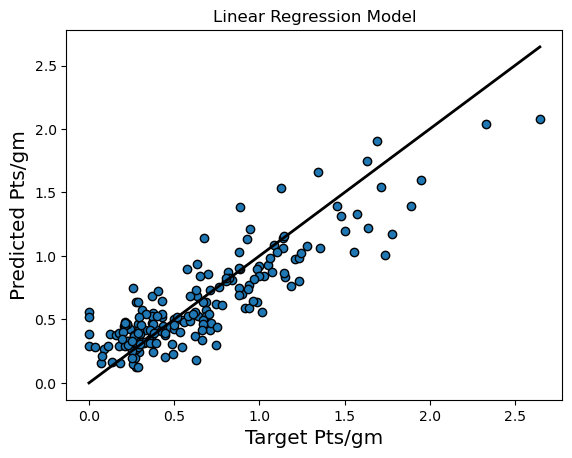

In [26]:
fig, ax = plt.subplots()
ax.scatter(y_test, model.predict(X_test), edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=2)
ax.set_xlabel('Target Pts/gm', size='x-large')
ax.set_ylabel('Predicted Pts/gm', size='x-large')
plt.title("Linear Regression Model")
plt.savefig('plot.png')

In [27]:
# Lancer le VotingClassifier
model_names = ['XGBoost', 'LogisticRegression', 'SVR', 'SGD']
model = train_ensemble(X_train, y_train, model_names)

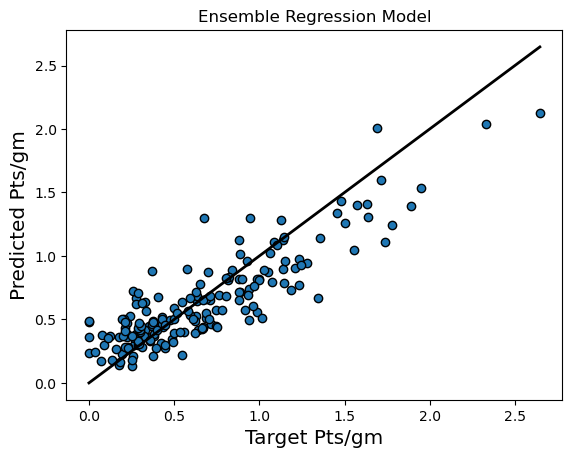

In [28]:
fig, ax = plt.subplots()
ax.scatter(y_test, model.predict(X_test), edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=2)
ax.set_xlabel('Target Pts/gm', size='x-large')
ax.set_ylabel('Predicted Pts/gm', size='x-large')
plt.title("Ensemble Regression Model")
plt.savefig('plot.png')

In [29]:
# extract data for the last two seasons to predict the new one
pred_data = []
for player in player_stats:
        years = ['20222023', '20232024', '20242025']
        data = {'name': player.name,
                'role': player.role,
                'country': player.country,
                'age': player.age,
                'id': player.id,
                'height': player.height,
                'weight': player.weight
                }
        data = {**data, **process_data.get_year_data_skaters(player, years[0], '1'), **process_data.get_year_data_skaters(player, years[1], '2')}
        data['season_1'] = years[0]
        data['season_2'] = years[1]
        data['season_3'] = years[2]
        pred_data.append(data)

In [30]:
df_pred = pd.DataFrame(pred_data)
df_pred

,name,role,country,age,id,height,weight,goals_1,assists_1,pim_1,...,assists_2,pim_2,games_2,shots_2,time_2,plus_minus_2,team_2,season_1,season_2,season_3
0,James Neal,A,CAN,37,8471707,191,96,0,0,0,...,0,0,0,0,0,0,0,20222023,20232024,20242025
1,Kris Russell,D,CAN,37,8471729,178,77,0,0,0,...,0,0,0,0,0,0,0,20222023,20232024,20242025
2,Kyle Turris,A,CAN,35,8474068,185,86,0,0,0,...,0,0,0,0,0,0,0,20222023,20232024,20242025
3,Tyler Ennis,A,CAN,35,8474589,175,73,0,0,0,...,0,0,0,0,0,0,0,20222023,20232024,20242025
4,Alex Chiasson,A,CAN,34,8475163,193,94,6,3,6,...,0,0,0,0,0,0,0,20222023,20232024,20242025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,Shane Wright,A,CAN,20,8483524,183,87,1,1,2,...,1,0,8,12,13:32,1,Kraken,20222023,20232024,20242025
1341,Tye Kartye,A,CAN,23,8481789,180,92,3,2,2,...,9,37,77,109,11:50,-1,Kraken,20222023,20232024,20242025
1342,Ryan Winterton,A,CAN,21,8482751,188,79,0,0,0,...,0,0,9,10,9:20,-1,Kraken,20222023,20232024,20242025
1343,Ryker Evans,D,CAN,23,8482858,180,86,0,0,0,...,8,20,36,44,19:11,-5,Kraken,20222023,20232024,20242025


In [31]:
df_pred = process_data.process_data_skaters(df_pred)
df_pred = df_pred[df_pred['role']!='N/A']

In [32]:
df_pred_final = df_pred[['name', 'games_1', 'games_2', 'goals_1', 'goals_2',
               'height', 'pim_1',
               'pim_2', 'plus_minus_1', 'plus_minus_2', 'role',
               'shots_1', 'shots_2', 'time_1',
               'time_2', 'weight', 'points_1', 'points_2', 'age']]

df_pred_final = df_pred_final.fillna(0)
df_pred_final = pd.get_dummies(df_pred_final, columns=['role'])

df_pred_final = normalize_data(df_pred_final, standardization)

In [33]:
predictions = df_pred_final[['name']]
predictions['ppg'] = model.predict(df_pred_final.drop('name', axis=1))
predictions = predictions.groupby(['name']).max().reset_index()

/tmp/ipykernel_44575/1411467764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['ppg'] = model.predict(df_pred_final.drop('name', axis=1))


In [34]:
predictions = predictions.sort_values('ppg', ascending=False)
predictions

,name,ppg
289,Connor McDavid,2.056311
932,Nathan MacKinnon,2.009608
327,David Pastrnak,1.944783
117,Auston Matthews,1.916827
970,Nikita Kucherov,1.864371
...,...,...
1176,Shea Weber,0.132346
173,Braydon Coburn,0.127981
1340,Zack Kassian,0.125876
51,Alexander Edler,0.118656


In [35]:
final_player_list = []
for player_name in predictions['name'].unique():
    for player in reduced_player_stats:
        if player.name == player_name:
            player.predict_points = predictions.loc[predictions['name']==player_name]['ppg'].item()
            if player.predict_points > 0:
                final_player_list.append(player)

In [36]:
final_player_list = final_player_list[:]
player_roles = [p.role for p in final_player_list]
print("Players Composition", player_roles.count('A'), 'A,', player_roles.count('D'), 'D,', player_roles.count('G'), 'G')


Players Composition 429 A, 216 D, 0 G


# Branch-and-Bound Algorithm to choose the best pool team
Note: The goalies are missing and are to be added in the futur using the same method

In [37]:
from pool_classifier import team_optimization_branch_and_bound, solve_problem

In [38]:
# resolving using LP livrary to compare results
selected_players, total_ppg, total_salary = solve_problem(final_player_list.copy())
print("Selected Players:", selected_players)
print("Total PPG:", total_ppg)
print("Total Salary:", total_salary)
pd.DataFrame(selected_players, columns=['name']).to_csv('best_solution_LPSolver.csv')

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ggenois/anaconda3/envs/rapids-24.08/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/e59e68c728324dbb9dea5a04ef867dfb-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/e59e68c728324dbb9dea5a04ef867dfb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 3235 RHS
At line 3240 BOUNDS
At line 3886 ENDATA
Problem MODEL has 4 rows, 645 columns and 1290 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 23.1129 - 0.00 seconds
Cgl0004I processed model has 3 rows, 531 columns (531 integer (531 of which binary)) and 1062 elements
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.204255
Cbc0038I Solution found of -23.0337
Cbc0038I Before mini branch and bound, 529 integers at bound fixed and 0 continuous
Cbc0038I Full problem 3 rows 531 

In [ ]:
# algo branch-and-bound custom made
best_team, best_ppg = team_optimization_branch_and_bound(final_player_list.copy())
print("Selected Players:", [p.name for p in best_team])
print("Total PPG:", best_ppg)
print("Total Salary:", sum(p.salary for p in best_team))
team_roles = [p.role for p in best_team]
print("Team Composition", team_roles.count('A'), 'A,', team_roles.count('D'), 'D,', team_roles.count('G'), 'G')

results = []
for player in best_team:
    results.append([player.id, player.name, player.salary, player.predict_points])
pd.DataFrame(results, columns=['name']).to_csv('best_solution_BnB.csv')